# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [1]:
# Import numpy and pandas
import numpy as np
import pandas as pd 


import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose


# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [2]:
# Run this code:

sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [3]:
# Your code here:
sensor.head()


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [4]:
# Your code here:
sensor[sensor.isnull().any(axis=1)]

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z


In [5]:
sensor.isna().sum()

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [6]:
# Your code here:
sensor.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   attitude.roll       1751 non-null   float64
 1   attitude.pitch      1751 non-null   float64
 2   attitude.yaw        1751 non-null   float64
 3   gravity.x           1751 non-null   float64
 4   gravity.y           1751 non-null   float64
 5   gravity.z           1751 non-null   float64
 6   rotationRate.x      1751 non-null   float64
 7   rotationRate.y      1751 non-null   float64
 8   rotationRate.z      1751 non-null   float64
 9   userAcceleration.x  1751 non-null   float64
 10  userAcceleration.y  1751 non-null   float64
 11  userAcceleration.z  1751 non-null   float64
dtypes: float64(12)
memory usage: 164.3 KB


To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [7]:
# Your code here:

time = pd.date_range("01/01/2018 00:00:00", "01/01/2018 00:29:10", periods=1751)
time = pd.DataFrame(time)

Assign the time series index to the dataframe's index.

In [8]:
# Your code here:
sensor = pd.concat([sensor.reset_index(drop=True),time.reset_index(drop=True)], axis=1)

In [9]:
sensor

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,0
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,2018-01-01 00:00:00
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,2018-01-01 00:00:01
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,2018-01-01 00:00:02
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,2018-01-01 00:00:03
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,2018-01-01 00:00:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,1.797120,-0.562324,2.445889,0.824443,0.533154,0.189844,-0.123211,0.909536,-0.379757,-0.268367,0.006733,-0.064874,2018-01-01 00:29:06
1747,1.814297,-0.569719,2.449655,0.817212,0.539396,0.203020,-0.057641,0.723118,-0.437812,-0.102444,-0.060666,-0.229738,2018-01-01 00:29:07
1748,1.830821,-0.578367,2.447967,0.809207,0.546658,0.215288,0.343238,0.997236,-0.338155,-0.085590,-0.030209,-0.087740,2018-01-01 00:29:08
1749,1.849557,-0.586962,2.439458,0.800485,0.553834,0.229110,0.470144,1.227937,-0.332223,-0.048105,0.029555,0.060441,2018-01-01 00:29:09


In [10]:
sensor = sensor.set_index(0)
sensor

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,,,,,,,,,,,,
2018-01-01 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
2018-01-01 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2018-01-01 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
2018-01-01 00:00:03,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
2018-01-01 00:00:04,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 00:29:06,1.797120,-0.562324,2.445889,0.824443,0.533154,0.189844,-0.123211,0.909536,-0.379757,-0.268367,0.006733,-0.064874
2018-01-01 00:29:07,1.814297,-0.569719,2.449655,0.817212,0.539396,0.203020,-0.057641,0.723118,-0.437812,-0.102444,-0.060666,-0.229738
2018-01-01 00:29:08,1.830821,-0.578367,2.447967,0.809207,0.546658,0.215288,0.343238,0.997236,-0.338155,-0.085590,-0.030209,-0.087740


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

In [11]:
# Your code here:
from statsmodels.tsa.stattools import adfuller


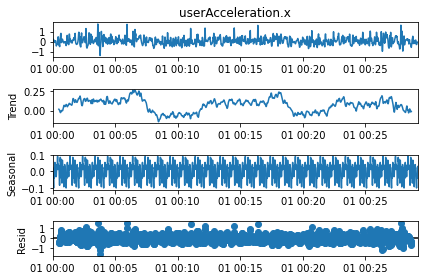

In [12]:
res = seasonal_decompose(sensor['userAcceleration.x'], period = 60)
res.plot();

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

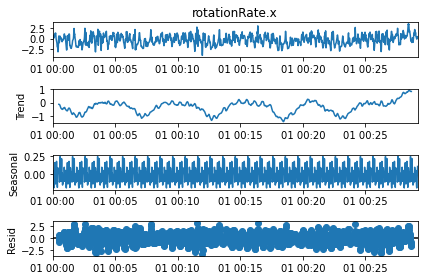

In [13]:
res = seasonal_decompose(sensor['rotationRate.x'], period = 60)
res.plot();

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

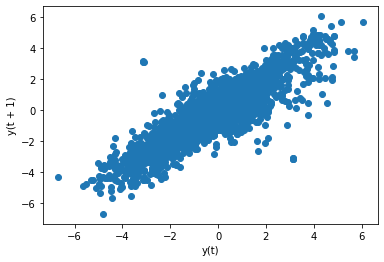

In [14]:
# Your code here:
pd.plotting.lag_plot(sensor, lag=1);


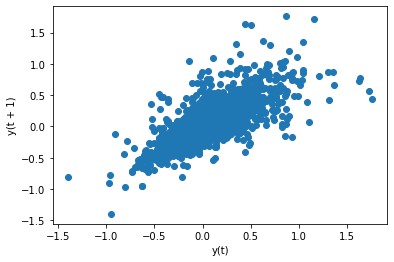

In [15]:
pd.plotting.lag_plot(sensor['userAcceleration.x'], lag=1);


Create a lag plot for `rotationRate.x`

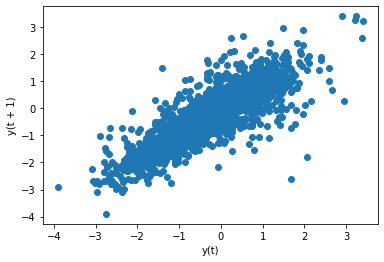

In [16]:
# Your code here:
pd.plotting.lag_plot(sensor['rotationRate.x'], lag=1);


What are your conclusions from both visualizations?

In [17]:
# Your conclusions here:
# The second graph looks more like a continued line than the the first one ? 


The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [18]:
# Your code here:
from statsmodels.tsa.stattools import adfuller

res_1 = adfuller(sensor["userAcceleration.x"])
res_1

(-17.95799408616974,
 2.823439483037563e-30,
 4,
 1746,
 {'1%': -3.434100824760071,
  '5%': -2.863196780129223,
  '10%': -2.5676520210882936},
 -727.6140124402791)

In [19]:
res_1[1]

2.823439483037563e-30

In [20]:
res_2 = adfuller(sensor["rotationRate.x"])
res_2

(-5.269860625086421,
 6.320230335912189e-06,
 25,
 1725,
 {'1%': -3.4341465551936534,
  '5%': -2.863216966926812,
  '10%': -2.567662770090317},
 2619.6049719981947)

In [21]:
res_2[1]

6.320230335912189e-06

What are your conclusions from this test?

In [22]:
# Your conclusions here:
# Both stationary because P-value is less 0.05 


## Bonus: Challenge 2

Finally, we'll create an ARIMA model for `userAcceleration.x`. Load the `ARIMA` function from `statsmodels`. The order of the model is (2, 0, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from random import random

In [24]:
order = (2, 0, 1)

In [25]:
# 0. Splitting into train & test
y_train = sensor["userAcceleration.x"][:-10]
y_test = sensor["userAcceleration.x"][-11:]

In [26]:
# 1. Create an instance of the ARIMA model that takes y_train, the order, and freq="S"
# Docs: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html

model = ARIMA(y_train, order = order, freq='s')
model

C:\Users\rapha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  warnings.warn('No frequency information was'


In [27]:
# 2. Fit the model:
model = ARIMA(y_train, order = order, freq='s').fit()


C:\Users\rapha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  warnings.warn('No frequency information was'


In [28]:
model.mae

0.1363478103646515

In [29]:
model.mse

0.03811710742650935

In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     userAcceleration.x   No. Observations:                 1741
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 373.401
Date:                Wed, 09 Nov 2022   AIC                           -736.803
Time:                        17:18:07   BIC                           -709.492
Sample:                    01-01-2018   HQIC                          -726.704
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0637      0.016      3.994      0.000       0.032       0.095
ar.L1          0.9882      0.036     27.630      0.000       0.918       1.058
ar.L2         -0.3788      0.033    -11.637      0.000      -0.443      -0.315
ma.L1          0.1824      0.039      4.643      0.000       0.105       0.259
sigma2         0.0381      0.001     46.070      0.000       0.036       0.040
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1776.70
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.34
Prob(H) (two-sided):                  0.60   Kurtosis:                         7.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# 3. Predict: create y_pred:
sensor["forecasting_arima"] = model.predict()
sensor


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,forecasting_arima
0,,,,,,,,,,,,,
2018-01-01 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,0.063734
2018-01-01 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,0.239251
2018-01-01 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,0.127263
2018-01-01 00:00:03,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,-0.068712
2018-01-01 00:00:04,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,0.023540
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 00:29:06,1.797120,-0.562324,2.445889,0.824443,0.533154,0.189844,-0.123211,0.909536,-0.379757,-0.268367,0.006733,-0.064874,NaN
2018-01-01 00:29:07,1.814297,-0.569719,2.449655,0.817212,0.539396,0.203020,-0.057641,0.723118,-0.437812,-0.102444,-0.060666,-0.229738,NaN
2018-01-01 00:29:08,1.830821,-0.578367,2.447967,0.809207,0.546658,0.215288,0.343238,0.997236,-0.338155,-0.085590,-0.030209,-0.087740,NaN


In [32]:
y_pred = model.predict(len(y_train),len(y_train)+9)
y_pred

2018-01-01 00:29:01    0.173146
2018-01-01 00:29:02    0.142889
2018-01-01 00:29:03    0.100513
2018-01-01 00:29:04    0.070097
2018-01-01 00:29:05    0.056091
2018-01-01 00:29:06    0.053770
2018-01-01 00:29:07    0.056783
2018-01-01 00:29:08    0.060638
2018-01-01 00:29:09    0.063308
2018-01-01 00:29:10    0.064485
Freq: S, Name: predicted_mean, dtype: float64

In [35]:
# Viz mantra
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go

ModuleNotFoundError: No module named 'plotly'

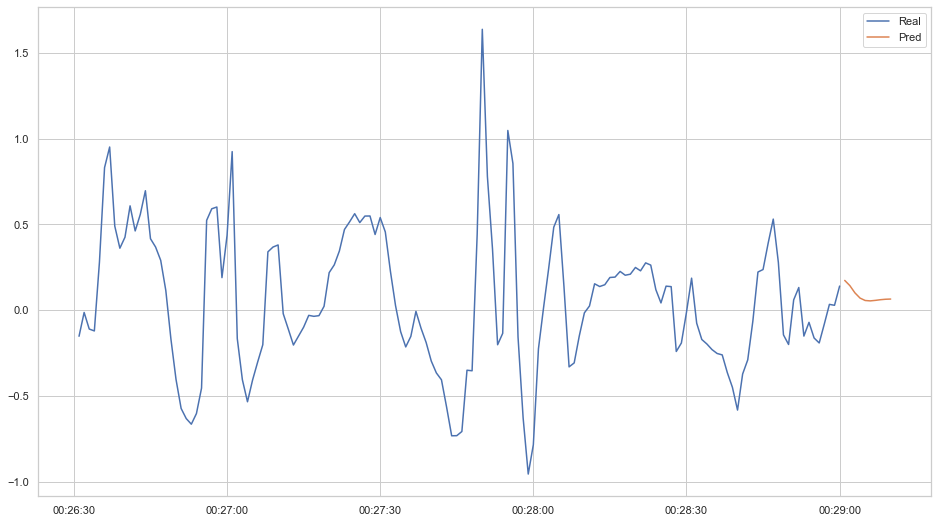

In [36]:
# 4. Visualize
plt.plot(y_train[-150:], label = "Real")
plt.plot(y_pred[-150:], label = "Pred")
plt.legend()

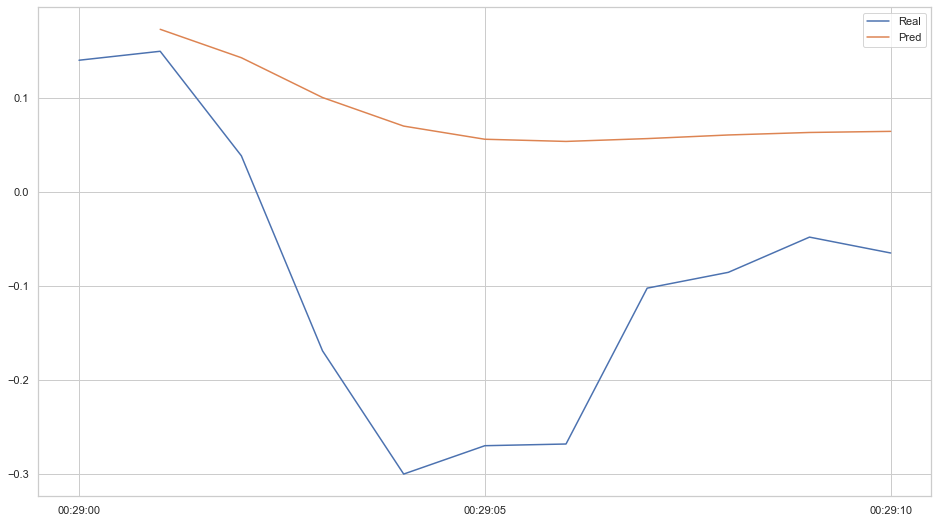

In [37]:
plt.plot(y_test, label = "Real")
plt.plot(y_pred, label = "Pred")
plt.legend()

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [40]:
# Your code here:

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

rmse(y_pred, y_test)

0.22529160449894864

In [39]:
y_test = sensor["userAcceleration.x"][-10:]
y_pred

2018-01-01 00:29:01    0.173146
2018-01-01 00:29:02    0.142889
2018-01-01 00:29:03    0.100513
2018-01-01 00:29:04    0.070097
2018-01-01 00:29:05    0.056091
2018-01-01 00:29:06    0.053770
2018-01-01 00:29:07    0.056783
2018-01-01 00:29:08    0.060638
2018-01-01 00:29:09    0.063308
2018-01-01 00:29:10    0.064485
Freq: S, Name: predicted_mean, dtype: float64